In [ ]:
# !pip install nibabel
# !pip PIL
# !pip install numpy

In [ ]:
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob
from tqdm import tqdm
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import cv2
from skimage.transform import resize

# Connect to the google drive

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Changing the directory
%cd '/content/drive/MyDrive/DSGP'

/content/drive/MyDrive/DSGP


# Partition the data

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define dataset paths
satellite_images_path = "satellite_image"  # Satellite images
mask_images_path = "Mask"  # Mask images

# Output dataset folder
output_dir = "split_dataset"
train_dir = os.path.join(output_dir, "training")
val_dir = os.path.join(output_dir, "validation")
test_dir = os.path.join(output_dir, "testing")

# Create directories for training, validation, and testing sets
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(d, "images"), exist_ok=True)
    os.makedirs(os.path.join(d, "masks"), exist_ok=True)

# Get all satellite image filenames (assuming they are in .jpg format)
image_filenames = sorted([f for f in os.listdir(satellite_images_path) if f.endswith('.jpg')])

# Ensure corresponding mask exists (assuming masks are in .png format)
valid_images = [
    f for f in image_filenames if os.path.exists(os.path.join(mask_images_path, os.path.splitext(f)[0] + '.png'))
]

print(f"Total valid image-mask pairs found: {len(valid_images)}")

# Split dataset: 70% train, 15% validation, 15% test
train_files, test_files = train_test_split(valid_images, test_size=0.30, random_state=42, shuffle=True)
val_files, test_files = train_test_split(test_files, test_size=0.50, random_state=42, shuffle=True) # Splitting remaining 30% into 15% each

# Function to copy files
def move_files(file_list, src_img, src_mask, dest):
    for f in file_list:
        mask_filename = os.path.splitext(f)[0] + '.png'  # Construct corresponding mask filename
        shutil.copy(os.path.join(src_img, f), os.path.join(dest, "images", f))
        shutil.copy(os.path.join(src_mask, mask_filename), os.path.join(dest, "masks", mask_filename))

# Move files to respective folders
move_files(train_files, satellite_images_path, mask_images_path, train_dir)
move_files(val_files, satellite_images_path, mask_images_path, val_dir)
move_files(test_files, satellite_images_path, mask_images_path, test_dir)

print("Dataset successfully split into Training, Validation, and Testing sets!")


Total valid image-mask pairs found: 314
Dataset successfully split into Training, Validation, and Testing sets!


# Visualize raw data

In [ ]:
# Plot image and its corresponding segmentation mask
def plot_images(img, mask):
    if img is None or mask is None:
        print("Error: One or both files could not be loaded.")
        return

    print("img shape:", img.shape)
    print("mask shape:", mask.shape)
    print("mask min:", mask.min())
    print("mask max:", mask.max())
    print("mask unique values:", np.unique(mask))

    viz_dict = {"Image": img, "Segmentation Map": mask}

    fig = plt.figure(figsize=(15, 15))

    count = 2
    for i, j in viz_dict.items():
        ax = plt.subplot(1, 3, count)
        plt.imshow(j, cmap='gray')
        plt.title(i)
        plt.axis("on")
        count += 1


def plot_images_by_path(image_path, mask_path):
    # Check if files exist
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return

    if not os.path.exists(mask_path):
        print(f"Error: Mask file not found at {mask_path}")
        return

    img = cv2.imread(image_path)  # Load the image in color (BGR format)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load the mask in grayscale (binary)

    plot_images(img, mask)


def plot_images_after_cleaning(img,mask):

  print("img " , img.shape)
  print("mask ", mask.shape)
  print("mask min ", mask.min())
  print("mask max ", mask.max())
  print("mask unique values ", np.unique(mask))

  viz_dict = {"Image": img[:,:,0], "Segmentation Map": mask}
  fig = plt.figure(figsize=(15, 15))

  count = 2

  for i, j in viz_dict.items():
    ax = plt.subplot(1, 3, count)
    plt.imshow(j)
    plt.colorbar()
    plt.title(i)
    plt.axis("on")
    count += 1


img shape: (1722, 1156, 3)
mask shape: (1722, 1156)
mask min: 0
mask max: 255
mask unique values: [  0 255]


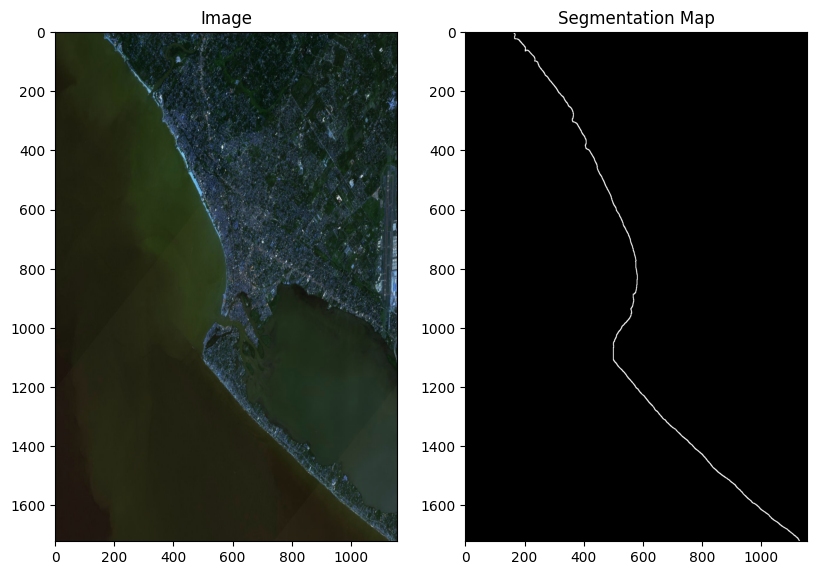

In [ ]:
image_path = 'split_dataset/training/images/sentinel2_void_2018-12-17_Negombo.jpg'
mask_path =  'split_dataset/training/masks/sentinel2_void_2018-12-17_Negombo.png'

plot_images_by_path(image_path, mask_path)

# Slect and load the data

In [ ]:
import glob
import cv2
import os
from tqdm import tqdm

# Function to select image and mask files from the dataset
def select_data(split_type, datatype_annotation):
    """
    Selects images and masks from the correct split folder.

    Args:
    - split_type (str): "training", "validation", or "testing"
    - datatype_annotation (str): "images" or "masks"

    Returns:
    - List of sorted file paths
    """
    base_path = "split_dataset"
    file_input = os.path.join(base_path, split_type, datatype_annotation, "*")
    return sorted(glob.glob(file_input))

# Function to load images and masks
def load_data(image_filenames, mask_filenames):
    """
    Loads images and masks from given file lists.

    Args:
    - image_filenames (list): List of image file paths.
    - mask_filenames (list): List of mask file paths.

    Returns:
    - images (list): List of loaded images (RGB format).
    - masks (list): List of loaded masks (grayscale).
    """
    images = []
    masks = []

    # Load images
    for file_name in tqdm(image_filenames, desc="Loading Images"):
        img = cv2.imread(file_name)  # Read image in BGR format
        if img is None:
            print(f"Error: Unable to load {file_name}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        images.append(img)

    # Load masks
    for file_name in tqdm(mask_filenames, desc="Loading Masks"):
        mask = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        if mask is None:
            print(f"Error: Unable to load {file_name}")
            continue
        masks.append(mask)

    return images, masks

In [ ]:
import cv2
import glob
import os
import numpy as np
from tqdm import tqdm

# Function to select image and mask files from the dataset
def select_data(split_type, datatype_annotation):
    """
    Selects images and masks from the correct split folder.

    Args:
    - split_type (str): "training", "validation", or "testing"
    - datatype_annotation (str): "images" or "masks"

    Returns:
    - List of sorted file paths
    """
    base_path = "/content/drive/MyDrive/DSGP/split_dataset"
    file_input = os.path.join(base_path, split_type, datatype_annotation, "*")
    return sorted(glob.glob(file_input))

# Function to crop an image to a square from the center
def crop_to_square(image):
    """
    Crops an image to the largest square possible from the center.

    Args:
    - image (numpy array): Input image (H, W, C) or (H, W)

    Returns:
    - Cropped square image (numpy array)
    """
    height, width = image.shape[:2]  # Get image dimensions
    min_dim = min(height, width)  # Find the shortest side

    # Calculate center crop box
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim

    return image[top:bottom, left:right]  # Crop and return

# Function to load images and masks with cropping & resizing
def load_data(image_filenames, mask_filenames):
    """
    Loads images and masks from given file lists with cropping.

    Args:
    - image_filenames (list): List of image file paths.
    - mask_filenames (list): List of mask file paths.

    Returns:
    - images (list): List of loaded images (RGB, square cropped).
    - masks (list): List of loaded masks (grayscale, square cropped).
    """
    images = []
    masks = []

    # Load images
    for file_name in tqdm(image_filenames, desc="Loading & Cropping Images"):
        img = cv2.imread(file_name)  # Read image in BGR format
        if img is None:
            print(f"Error: Unable to load {file_name}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = crop_to_square(img)  # Crop to square
        images.append(img)

    # Load masks
    for file_name in tqdm(mask_filenames, desc="Loading & Cropping Masks"):
        mask = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        if mask is None:
            print(f"Error: Unable to load {file_name}")
            continue
        mask = crop_to_square(mask)  # Crop to square
        masks.append(mask)

    return images, masks

## Training

In [ ]:
# Select files for training images and masks
training_image_files = select_data('training', 'images')  # Select images from 'training/images'
training_mask_files = select_data('training', 'masks')  # Select masks from 'training/masks'

# Load training images and masks
training_images, training_masks = load_data(training_image_files, training_mask_files)

# Print sample information
print(f"\nTraining images loaded: {len(training_images)}")
print(f"Training masks loaded: {len(training_masks)}")


Loading & Cropping Masks: 100%|██████████| 219/219 [00:05<00:00, 39.44it/s]


Training images loaded: 219
Training masks loaded: 219


## Testing

In [ ]:
# Select files for testing images and masks
testing_image_files = select_data('testing', 'images')  # Select images from 'testing/images'
testing_mask_files = select_data('testing', 'masks')  # Select masks from 'testing/masks'

# Load testing images and masks
testing_images, testing_masks = load_data(testing_image_files, testing_mask_files)

# Print sample information
print(f"Testing images loaded: {len(testing_images)}")
print(f"Testing masks loaded: {len(testing_masks)}")


Loading & Cropping Masks: 100%|██████████| 48/48 [00:01<00:00, 42.51it/s]

Testing images loaded: 48
Testing masks loaded: 48


## Validation

In [ ]:
# Select files for validation images and masks
validation_image_files = select_data('validation', 'images')  # Select images from 'validation/images'
validation_mask_files = select_data('validation', 'masks')  # Select masks from 'validation/masks'

# Load validation images and masks
validation_images, validation_masks = load_data(validation_image_files, validation_mask_files)

# Print sample information
print(f"Validation images loaded: {len(validation_images)}")
print(f"Validation masks loaded: {len(validation_masks)}")


Loading & Cropping Masks: 100%|██████████| 47/47 [00:01<00:00, 39.63it/s]

Validation images loaded: 47
Validation masks loaded: 47


# Formating

- resizing the image

In [ ]:
def resize_images(images_raw, masks_raw,target_size=(512, 512)):
  images = []
  masks = []

  for img, msk in zip(images_raw, masks_raw):
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)  # Resize to target size
    msk = cv2.resize(msk, target_size, interpolation=cv2.INTER_NEAREST)  # Resize masks using NEAREST interpolation

    if len(msk.shape) == 3:  # If it accidentally gets converted to 3 channels
        msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)

    images.append(img)
    masks.append(msk)


  return images, masks;

In [ ]:
# Trainning data resize
training_images, training_masks = resize_images(training_images, training_masks)

# Testing data resize
testing_images, testing_masks = resize_images(testing_images, testing_masks)

# Validation data resize
validation_images, validation_masks = resize_images(validation_images, validation_masks)

In [ ]:
print(f"Validation images count: {len(validation_images)}")
print(f"Validation masks count: {len(validation_masks)}")


Validation images count: 47
Validation masks count: 47


img  (512, 512, 3)
mask  (512, 512)
mask min  0
mask max  255
mask unique values  [  0 255]


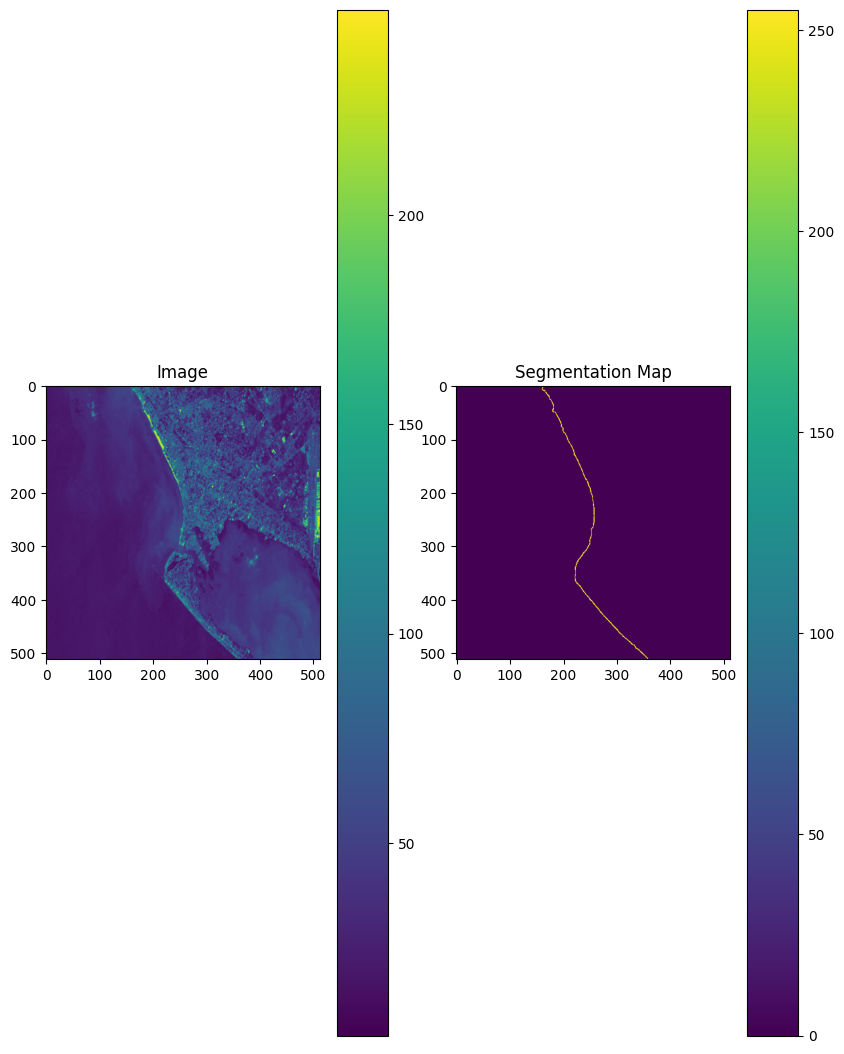

In [ ]:
plot_images_after_cleaning(validation_images[0], validation_masks[0])

In [ ]:
import os
import numpy as np

# Define base directory in Google Drive
base_dir = "split_dataset"

# Define NumPy save paths
numpy_train_path = os.path.join(base_dir, "training", "numpy")
numpy_test_path = os.path.join(base_dir, "testing", "numpy")
numpy_val_path = os.path.join(base_dir, "validation", "numpy")

# Ensure directories exist
os.makedirs(numpy_train_path, exist_ok=True)
os.makedirs(numpy_test_path, exist_ok=True)
os.makedirs(numpy_val_path, exist_ok=True)

# Save NumPy arrays
np.save(os.path.join(numpy_train_path, "images.npy"), training_images)
np.save(os.path.join(numpy_train_path, "masks.npy"), training_masks)

np.save(os.path.join(numpy_test_path, "images.npy"), testing_images)
np.save(os.path.join(numpy_test_path, "masks.npy"), testing_masks)

np.save(os.path.join(numpy_val_path, "images.npy"), validation_images)
np.save(os.path.join(numpy_val_path, "masks.npy"), validation_masks)

print("NumPy arrays saved successfully!")


NumPy arrays saved successfully!


img shape: (512, 512, 3)
mask shape: (512, 512)
mask min: 0
mask max: 255
mask unique values: [  0 255]


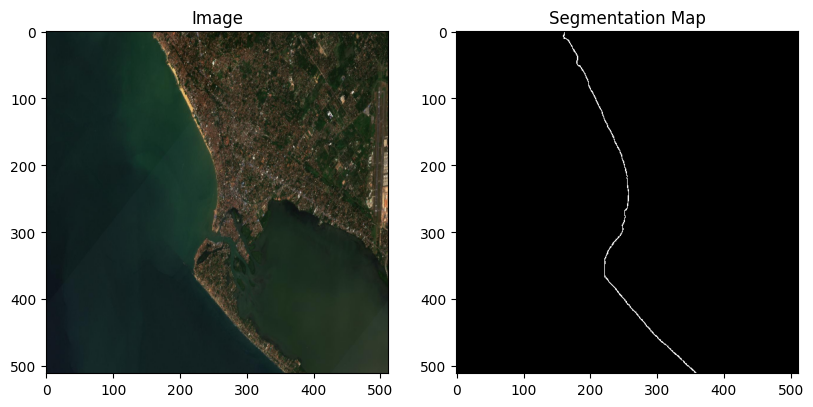

In [ ]:
plot_images(training_images[0],training_masks[0])